In [2]:
import sys

if 'google.colab' in sys.modules:
    !rm -rf *
    !git clone https://github.com/Tinynja/Sarsa-phi-EB
    !mv Sarsa-phi-EB/* .
    !rm -rf Sarsa-phi-EB
    # DON'T install packages defined in Pipfile_Colab_exclude
    !sed -ri "/$(tr '\n' '|' < Pipfile_Colab_exclude)/d" Pipfile
else:
    print('Skipping GitHub cloning since not running in Colab.')

Cloning into 'Sarsa-phi-EB'...
remote: Enumerating objects: 358, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (304/304), done.
remote: Total 358 (delta 123), reused 209 (delta 41), pack-reused 0
Receiving objects: 100% (358/358), 860.79 KiB | 11.96 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [3]:
# Install required dependencies
import os

if 'google.colab' in sys.modules:
    # Some dependencies required for displaying episode
    !apt install -y python-opengl xvfb 1> /dev/null
    !pip install pyvirtualdisplay 1> /dev/null
    # Colab doesn't support pipenv, hence we convert Pipfile into requirements.txt
    if 'requirements_Colab.txt' not in os.listdir():
        !pip install pipenv
        !pipenv lock -r > requirements.txt
    !pip install -r requirements_Colab.txt 1> /dev/null
else:
    !pipenv install 1> /dev/null



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.0.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
# Import all supported ROMs into ALE
!ale-import-roms ROMS

[SUPPORTED]                 surround ROMS/Surround - Chase (Blockade) (1977).bin
[SUPPORTED]                king_kong      ROMS/King Kong (1982).bin
[SUPPORTED]          elevator_action ROMS/Elevator Action (1983).bin
[SUPPORTED]                 air_raid ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin
[SUPPORTED]                 crossbow       ROMS/Crossbow (1988).bin
[SUPPORTED]               backgammon ROMS/Backgammon (Paddle) (1979).bin
[SUPPORTED]                  solaris ROMS/Solaris (The Last Starfighter, Star Raiders II, Universe) (1986).bin
[SUPPORTED]              word_zapper ROMS/Word Zapper (Word Grabber) (1982).bin
[SUPPORTED]                asteroids      ROMS/Asteroids (1981).bin
[SUPPORTED]                  asterix ROMS/Asterix (AKA Taz) (1984).bin
[SUPPORTED]                   pacman        ROMS/Pac-Man (1982).bin
[SUPPORTED]                   pooyan         ROMS/Pooyan (1983).bin
[SUPPORTED]             lost_luggage ROMS/Lost Luggage (Airport Mayhem) (1982).bin
[SUPPORTED]   

In [5]:
#### ALE-related imports ####

# Built-in libraries
import re
import sys
import timeit
import base64
import pickle
import logging
import subprocess
from pathlib import Path
from datetime import datetime

# Pypi libraries
import gym
import torch
# import numpy as np
import matplotlib.pyplot as plt
from ale_py import ALEInterface, SDL_SUPPORT
import ale_py.roms as ROMS

# Episode display
from PIL import Image
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
Display().start()

# Configuration
CUDA = 'cuda' if torch.cuda.device_count() else 'cpu'
CPU = 'cpu'

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [6]:
class EnvRecorder:
    def __init__(self, env, out_dir='./results'):
        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(exist_ok=True)
        self.out_dir = self.out_dir.resolve()
        self.env = env

        # Workspace variables
        self.__frame_count_padding = 0
        self.__timestep = 0
    
    def __call__(self, choose_action=None, max_steps=-1, height=300):
        self.record_episode_and_show(choose_action=choose_action, max_steps=max_steps, height=height)
    
    def record_episode_and_show(self, choose_action=None, max_steps=-1, height=300):
        self.record_episode(choose_action=choose_action, max_steps=max_steps)
        self.show_recording(height=height)
    
    def record_episode(self, choose_action=None, max_steps=-1):
        """Generate an episode and record it as record.mp4
        Args:
        choose_action -- callable method that returns the next action based on the current observation
        max_steps     -- maximum number of steps after which force end episode
        """
        choose_action = choose_action or (lambda _: self.env.action_space.sample())

        self._clear_recording()
        self.__timestep, done, observation =  0, False, self.env.reset()
        self._record_frame()
        while not done and self.__timestep != max_steps:
            print(f'\rRecording episode, timestep {self.__timestep+1}...', end='')
            action = choose_action(observation)
            observation, _, done, _ = self.env.step(action)
            self.__timestep += 1
            self._record_frame()

        if self.__timestep == max_steps and not done:
            print('\nWarning: `max_steps` reached before episode terminated')
        else:
            print()

        self._export_as_mp4()

    def show_recording(self, height=300):
        """Show a .mp4 video in html format of the recorded episode"""
        filepath = self.out_dir.joinpath('record.mp4')
        video_b64 = base64.b64encode(filepath.read_bytes())
        html = f'''<video alt="{filepath}" autoplay loop controls style="height:{height}px">
                        <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
                   </video>'''
        ipythondisplay.display(ipythondisplay.HTML(data=html))

    def _clear_recording(self):
        # This is a new episode, delete previously recorded steps
        self.out_dir.joinpath('record').mkdir(exist_ok=True)
        for step_png in self.out_dir.glob('record/step_*.png'):
            step_png.unlink()
        if self.out_dir.joinpath('record.mp4').exists():
            self.out_dir.joinpath('record.mp4').unlink()
    
    def _record_frame(self):
        # Record current timestep png
        img = Image.fromarray(env.render('rgb_array'))
        out_path = self.out_dir.joinpath(f'record/step_{self.__timestep}.png')
        img.save(str(out_path))

    def _export_as_mp4(self):
        """Convert the recorded set of png files into an mp4 video"""
        self._standardize_frame_count_padding()
        in_dir = self.out_dir.joinpath('record')
        in_pattern = f'step_%0{self.__frame_count_padding}d.png'
        out_file = self.out_dir.joinpath('record.mp4')
        !cd $in_dir; ffmpeg -hide_banner -loglevel error -r 60 -i $in_pattern -vcodec libx264 -crf 25 -pix_fmt yuv420p -y $out_file
    
    def _standardize_frame_count_padding(self):
        self.__frame_count_padding = len(str(self.__timestep))
        number_pattern = re.compile('\d+')
        png_abs_glob = 'step_*.png'
        for png_path in self.out_dir.joinpath('record').glob(png_abs_glob):
            ts = int(number_pattern.search(png_path.stem).group(0))
            new_name = png_path.parent.joinpath(f'step_{ts:0{self.__frame_count_padding}d}.png')
            png_path.rename(new_name)

In [7]:
class features:
    @staticmethod
    def basic(frame, palette, background, crop_size=torch.Tensor([15,10]), flatten=True):
        # For each color in palette, tell if each pixel is that color (e.g. 210,160,128)
        colors_in_pixels = ((frame-background).unsqueeze(-2) == palette).all(-1)
        # Split the image into n tiles, each with dimension `crop_size` (e.g. 14,16,15,10,128)
        cropped_colors_in_pixels = torch.stack(torch.stack(colors_in_pixels.split(crop_size[1],dim=-2)).split(crop_size[0],dim=-3))
        # Apply logical or inside each cropped image (e.g. 14,16,128)
        cropped_features = cropped_colors_in_pixels.any(3).any(2)
        # Flatten the features (e.g. 28672)
        return cropped_features.flatten() if flatten else cropped_features
    
    @staticmethod
    def b_pros(frame, palette, background, crop_size=torch.Tensor([15,10])):
        raise NotImplementedError()
        basic_features = features.basic(frame, palette, background, crop_size=crop_size)
        b_pros_features = torch.combinations(basic_features)
        return b_pros_features
    
    @staticmethod
    def discretized_float(number, low, high, n_intervals):
        feature = torch.zeros(n_intervals+2, dtype=torch.bool)
        if number < low:
            feature[0] = True
        elif number >= high:
            feature[-1] = True
        else:
            interval = (high-low)/n_intervals
            index = int((number-low)/interval)
            feature[index+1] = True
        return feature

In [8]:
class BinaryEnv:
    def __init__(self, env_name, n_features, device=CUDA, *args, **kwargs):
        self.env = gym.make(env_name, *args, **kwargs)
        self.n_features = int(n_features/self.env.observation_space.shape[0])
        self.device = device

        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
    
    def reset(self, *args, **kwargs):
        observation = self.env.reset(*args, **kwargs)
        return self._binarize_observation(observation)

    def step(self, *args, **kwargs):
        observation, reward, done, info = self.env.step(*args, **kwargs)
        observation = self._binarize_observation(observation)
        return observation, reward, done, info

    def render(self, *args, **kwargs):
        return self.env.render(*args, **kwargs)
    
    def _binarize_observation(self, observation):
        bin_features = []
        lows, highs = self.env.observation_space.low, self.env.observation_space.high
        lows, highs = [-2] * 4, [2] * 4
        for i,obs in enumerate(observation):
            bin_features.append(features.discretized_float(obs, lows[i], highs[i], n_intervals=self.n_features))
        return torch.cat(bin_features).to(self.device)

In [9]:
from gym.spaces import Discrete, Box

class EnvALE:
    def __init__(self, rom, out_dir='results', seed=0, feature_type='ScreenRGB',
                 regen_bg=False, bg_samples=18000, device=CUDA):
        self.rom = rom
        self.rom_name = rom.stem
        self.feature_type = feature_type
        self.device = device

        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(exist_ok=True)
        self.out_dir = self.out_dir.resolve()

        # ALE
        self.ale = ALEInterface()
        self.ale.setInt("random_seed", seed)
        self.ale.loadROM(rom)

        # gym action_space compatibility
        action_set = self.ale.getMinimalActionSet()
        self.action_space = Discrete(len(action_set))
        self.action_space.action_set = action_set

        # color palette
        self.color_palette = self._get_color_palette().to(self.device)

        self._bg_path = Path(f'./backgrounds/{self.rom_name}.pickle')
        if regen_bg or not self._bg_path.exists() or not self._bg_path.is_file():
            self.background = self._get_background(n_samples=bg_samples)
        else:
            with open(self._bg_path, 'rb') as file:
                self.background = pickle.load(file).to(self.device)
        
        self._set_observe_method(feature_type)
        self.observation_space = Box(low=0, high=1, shape=self._observe().shape, dtype=bool)

    def reset(self, do_record=False):
        self.ale.reset_game()
        observation = self._observe()
        
        return observation
        
    def step(self, action):
        if isinstance(action, int):
            action = self.action_space.action_set[action]

        reward = self.ale.act(action)
        observation = self._observe()
        done = self.ale.game_over()
                
        return observation, reward, done, None

    def render(self, mode='rgb_array'):
        if mode == 'rgb_array':
            return self.ale.getScreenRGB()
        else:
            raise ValueError(f'render mode `{mode}` is not supported')

    def _set_observe_method(self, feature_type):
        if feature_type == 'ScreenRGB':
            self._observe = lambda: torch.from_numpy(self.ale.getScreenRGB()).to(self.device)
        elif feature_type == 'ScreenGrayscale':
            self._observe = lambda: torch.from_numpy(self.ale.getScreenGrayscale()).to(self.device)
        elif feature_type == 'Basic':
            self._observe = lambda: features.basic(frame=torch.from_numpy(self.ale.getScreenRGB()).to(self.device),
                                                   palette=self.color_palette,
                                                   background=self.background)
        elif feature_type == 'B-PROS':
            self._observe = lambda: features.b_pros(frame=torch.from_numpy(self.ale.getScreenRGB()).to(self.device),
                                                    palette=self.color_palette,
                                                    background=self.background)
        else:
            raise NotImplementedError(f'Feature type `{feature_type}` is not supported')
        
    def _observe(self):
        raise NotImplementedError()
    
    def _get_color_palette(self):
        result = subprocess.run(['python', '-c', f'__import__("ale_py").ALEInterface().loadROM("{str(self.rom)}")'], capture_output=True)
        palette_name = result.stderr.decode().splitlines()[6].strip().split()[-1]
        with open(f'palettes/{palette_name}_Palette.pickle', 'rb') as file:
            palette = pickle.load(file)
        return palette
    
    def _get_background(self, n_samples):
        bg_feature_type = 'ScreenRGB' if self.feature_type not in ['ScreenGrayscale',] else 'ScreenGrayscale'
        self._set_observe_method(bg_feature_type)
        
        sample_i = 0
        pixel_histogram = torch.zeros((*self.ale.getScreenDims(), self.color_palette.shape[0]), dtype=torch.int32).to(self.device)
        while sample_i < n_samples:
            done, observation = False, self.reset()
            while not done and sample_i < n_samples:
                if not sample_i%10:
                    print(f'\rGenerating background... {sample_i}/{n_samples} samples ({sample_i/n_samples:.0%})', end='')
                action = self.action_space.sample()
                observation, reward, done, info = self.step(action)
                colors_in_pixels = (observation.unsqueeze(-2) == self.color_palette).all(-1)
                pixel_histogram += colors_in_pixels
                sample_i += 1
        print('\r', end='')
        background_ids = pixel_histogram.argmax(axis=-1)
        background = self.color_palette[background_ids]
        
        self._bg_path.parent.mkdir(exist_ok=True)
        with open(self._bg_path, 'wb') as file:
            pickle.dump(background.cpu(), file)
        
        return background

In [10]:
#@title

if print("Skipped background regeneration."):
# if True:

    from ale_py.roms import *
    games_to_generate_bg = [Breakout, MontezumaRevenge, Venture, Qbert, Frostbite, Freeway]

    for game in games_to_generate_bg:
        print(f'\n{game.stem}')
        env = EnvALE(game, regen_bg=True, bg_samples=100)
        bg_np = env.background.cpu().to(torch.uint8).numpy()
        display(Image.fromarray(bg_np))

Skipped background regeneration.


In [11]:
#@title

if print("Skipped displaying stored backgrounds to reduce ouptuts."):
# if True:

    for filepath in Path('backgrounds').iterdir():
        print(f'\nBackground in `{filepath.resolve()}`')
        with open(filepath, 'rb') as file:
            bg = pickle.load(file)
        display(Image.fromarray(bg.to(torch.uint8).numpy()))

Skipped displaying stored backgrounds to reduce ouptuts.


In [12]:
#@title

if print("Skipped manual test."):
# if True:

    env = EnvALE(ROMS.Breakout)
    recorder = EnvRecorder(env)
    recorder()

Skipped manual test.


In [30]:
class SarsaPhiEBAgent:
    def __init__(self, env, alpha=0.5, gamma=0.99, lam=0.9, beta=0.05, init_action=1, step_repeat_count=1, device=CUDA, debug=False):
        """An agent using Sarsa(lambda) algorithm with:
            - Linear Function Approximation (SGD)
            - Replacing Traces
            - Exploration-Bonus
        
        Args:
                      env -- gym-like environment
                    alpha -- step size
                    gamma -- discount factor
                      lam -- trace decay
                     beta -- exploration bonus parameter
              init_action -- action to take after an environment reset
        step_repeat_count -- numer of times to repeat an action every timestep (under-the-hood) 
                   device -- device on which to store tensors
                    debug -- enable debug output
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.lam = lam
        self.beta = beta
        self.init_action = init_action
        self.step_repeat_count = step_repeat_count
        self.device = device
        self.epsilon = 0.1 #hardcoded

        self.__log = logging.Logger(name=self.__class__.__name__,
                                    level=(logging.DEBUG if debug else logging.WARNING))

        # Workspace variables
        self.feature_space_shape = (self.env.action_space.n, *self.env.reset().shape)
        self.weights = torch.zeros(self.feature_space_shape).to(self.device)
        self._counts = torch.zeros(self.feature_space_shape).to(self.device)
        self._total_steps = 0

    def learn(self, n_steps):
        start_time, done = timeit.default_timer(), True

        rewards = [0]
        episode_count = 0
        for i in range(n_steps):
            # Information display
            avg_time = (timeit.default_timer()-start_time)/(i or 1)
            print(f'\rSarsaPhiEB learning iteration {self._total_steps+1}/{self._total_steps-i+n_steps} ({1000*avg_time:.2f}ms/iter, remaining {(n_steps-i)*avg_time:.0f}s)    ', end='')
            # Reset env when episode ends
            if done:
                episode_count += 1
                rewards.append(0)
                next_phi = self.env.reset()
                if self.init_action is not None:
                    next_phi, _, _, _ = self.env.step(self.init_action)
                next_action = self._choose_action(next_phi)
                traces = torch.zeros(self.feature_space_shape).to(self.device)

            # Advance to next timestep
            phi, action = next_phi, next_action
            active_features = phi.nonzero()
            self._total_steps += 1

            # Take an action
            next_phi, reward, done, _ = self._step_repeat(action)
            next_action = self._choose_action(next_phi)
            rewards[episode_count] += reward

            # Apply exploration bonus
            self._counts[action,active_features] += 1
            # reward += self._calc_exploration_bonus(phi, action)

            # RL Algorithm : Sarsa(lambda) LFA(SGD) Replacing Traces
            traces *= self.gamma *  self.lam
            traces[action, active_features] = 1 # phi[active_features].to(traces.dtype)

            if not done:
                delta = reward + self.gamma * self._action_value(next_phi, next_action) - self._action_value(phi, action)
            else:
                # In terminal state, all state-action values are 0
                delta = reward - self._action_value(phi, action)
            self.weights += self.alpha * delta * traces

        print(f'\nTotal elapsed time: {datetime.utcfromtimestamp(timeit.default_timer()-start_time).strftime("%H:%M:%S.%f")}')
        return rewards
    
    def _step_repeat(self, action):
        for i in range(self.step_repeat_count):
            observation, reward, done, info = self.env.step(action)
            if done: break
        return observation, reward, done, info
    
    def _action_value(self, phi, action):
        return (self.weights[action]@phi.to(self.weights.dtype)).item()
    
    def _choose_action(self, phi):
        if torch.rand(1) > self.epsilon:
            return (self.weights@phi.to(self.weights.dtype)).argmax().item()
        else:
            return self.env.action_space.sample()
    
    def _calc_exploration_bonus(self, phi, action):
        # Compute the exploration bonus
        phi_occ = torch.cat((self._counts[action, phi], self._total_steps-self._counts[action, ~phi])).to(self.device)
        rho = ((phi_occ+1/2) / (self._total_steps+1)).prod()
        rho_prime = ((phi_occ+1+1/2) / (self._total_steps+1+1)).prod()
        pseudocount = (rho*(1-rho_prime)) / (rho_prime-rho)
        exploration_bonus = self.beta / pseudocount.sqrt()
        return exploration_bonus

In [31]:
env = BinaryEnv('CartPole-v1', 1000)
#env = EnvALE(ROMS.Breakout, feature_type='Basic')

agent = SarsaPhiEBAgent(env, init_action=0)
recorder = EnvRecorder(env)

rew = agent.learn(8000)

SarsaPhiEB learning iteration 8000/8000 (1.63ms/iter, remaining 0s)    
Total elapsed time: 00:00:13.005189


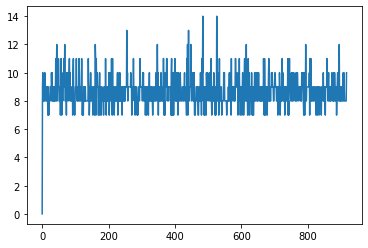

In [32]:
plt.plot(rew)
plt.show()

In [ ]:
recorder(choose_action=agent._choose_action, max_steps=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in float_scalars


Recording episode, timestep 8...


In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2017-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

# import numpy as np
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# from math import floor
# from tqdm import tqdm


# all possible actions
ACTIONS = range(4)

# discount is always 1.0 in these experiments
DISCOUNT = 0.99

# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0.01

# maximum steps per episode
STEP_LIMIT = 5000


# get action at @position and @velocity based on epsilon greedy policy and @valueFunction  #########################    use our own get_action. modified it, may work as intended
def get_action(observation, valueFunction):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        values.append(valueFunction.value(observation))  
    maxi = np.max(values)
    bestactions = np.where(values==maxi,1.0,0.0)
    for i in range(len(ACTIONS)):
      bestactions[i] = bestactions[i]*np.random.uniform()
    action = np.argmax(bestactions)
    return action



# replacing trace update rule
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @return: new trace for convenience
def replacing_trace(trace, activeTiles, lam):
    active = (torch.arange(len(trace)).to(device)[None,...] == activeTiles.flatten()[...,None]).any(0)
    trace[active] = 1
    trace[~active] *= lam * DISCOUNT
    return trace



# wrapper class for Sarsa(lambda)
class Sarsa:
    # In this example I use the tiling software instead of implementing standard tiling by myself
    # One important thing is that tiling is only a map from (state, action) to a series of indices
    # It doesn't matter whether the indices have meaning, only if this map satisfy some property
    # View the following webpage for more information
    # http://incompleteideas.net/sutton/tiles/tiles3.html
    # @maxSize: the maximum # of indices
    #the hashing is a lfa?
    def __init__(self, step_size, lam, trace_update=replacing_trace, max_size=28672, initial_weights=0):
        self.max_size = max_size
        self.trace_update = trace_update
        self.lam = lam

        # divide step size equally to each tiling
        self.step_size = step_size/10

        # weight for each tile
        if initial_weights == 0:
          self.weights =torch.zeros(max_size).to(device) #max size is the number of features?
        else:
          self.weights = initial_weights.to(device)

        # trace for each tile
        self.trace = torch.zeros(max_size).to(device)



    # estimate the value of given state and action
    def value(self, observation):
        active_tiles = np.nonzero(observation)
        return self.weights[active_tiles].sum()

    # learn with given state, action and target
    def learn(self, observation, target):
        active_tiles = np.nonzero(observation)
        estimation = self.weights[active_tiles].sum()
        delta = target - estimation
        #print('estimation array: ' + str(self.weights[active_tiles]))
        # print('estimation: ' + str(self.weights[active_tiles].sum()))
        if self.trace_update == replacing_trace:
            self.trace_update(self.trace, active_tiles, self.lam)
        else:
            raise Exception('Unexpected Trace Type')
        self.weights += self.step_size * delta * self.trace
        # print('delta: ' + str(delta))
        # print('weights: ' +  str(self.weights))


# play Mountain Car for one episode based on given method `evaluator`
# return: total steps in this episode
def play(evaluator, env):

    action = random.choice(ACTIONS)
    steps = 0
    while True:
        next_observation, reward, done, info = env.step(action)
        next_action = get_action(next_observation, evaluator)    #########################    use our own get_action  ??? modified it, may work as intented
        steps += 1
        target = reward + DISCOUNT * evaluator.value(next_observation)          ############# use our own value function ??? modified it, may work as intented
        evaluator.learn(observation, target)
        observation = next_observation
        action = next_action
        if done:
            break
        if steps >= STEP_LIMIT:
            print('Step Limit Exceeded!')
            break
    return steps

class BaseAgent:
  """ The base agent class function.
  """
  def __init__(self, nb_features=28672):
    #nothing for now
    self.gamma = 1
    self.features = nb_features
    self.rhos = torch.ones(self.features).to(device) #stores the rho_i values


  def takeAction(self, t):
    phis = [[0,1,0],[0,1,0],[0,1,0],[1,0,1]]
    return phis[t]


  def updateRho_i(self, counts, t):
    M = self.features
    self.rhos = (counts+1.5)/(t+1)
    return 0


  def PHI_EB(self, evaluator, env, beta=0.05, t_end=200):
    t = 0
    M = self.features #number of features
    counts = torch.zeros(M).to(device)
    states = torch.zeros(t_end,M).to(device) #stores the previous phis for all timesteps

    action = 1 #starting the game for the agent on the first game
    old_phi = env._observe()
    print('starting iterations')
    print('rhos: ' + str(self.rhos))
    while t < t_end:
    #   print("Iteration #{}".format(t))
      #observe phi(s), reward
    #   phi, reward, done, info = obs.clone(), 0, False, None
      phi, reward, done, info = env.step(action)
    #   print(phi.shape)
    #   print('--------------------------------------------------------------')
    #   print('took action: ', env.action_space[action])
      next_action = get_action(phi, evaluator)
    #   print('phi: ' + str(phi))
      
      #compute rho_t(phi) (feature visit-density)
      if t > 0:
        counts = (phi==states[0:t]).sum(0)
        # print(counts)
        self.rhos = (counts+0.5)/(t+1)
        # print('rhos: ' + str(self.rhos))
        rho_t = torch.prod(self.rhos)
      else:
        rho_t = 0.5**M
    #   print('rho_t ' + str(rho_t))
      #update all rho_i with observed phi
      states[t] = phi
      self.updateRho_i(counts, t+1)
    #   print('min rho_i_t: ' + str(min(self.rhos)))
      
      #compute rho_t+1(phi)
      new_rho_t = 1
      # THIS IS A BOTTLENECK (tested in CPU mode: 74ms -> 178ms)
      for i in range(M):
        new_rho_t = new_rho_t*self.rhos[i]
      if new_rho_t <= 1e-323: #this is to avoid division by zero, might need to be tweaked
        new_rho_t = 1e-323
    #   print('new_rho_t ' + str(new_rho_t))

      #compute Nhat_t(s)
      Nhat_t = rho_t*(1-new_rho_t)/(new_rho_t-rho_t)
    #   print('Nhat_t: ',   Nhat_t)
      if Nhat_t <= 1e-323: #this is to avoid division by zero again, might need to be tweaked
        Nhat_t = torch.tensor([1e-323]).to(device)

      #compute R(s,a) (empirical reward)
      explorationBonus = beta/torch.sqrt(Nhat_t)
      if torch.isnan(explorationBonus) or explorationBonus >= 1e3:
        explorationBonus = 1e3

      reward = reward + explorationBonus
    #   print('reward: ',reward)

    #   print('state value: ' + str(evaluator.value(phi)))
      #pass phi(s) and reward to RL algo to update theta_t
      target = reward + self.gamma * evaluator.value(phi)          ############# use our own value function ??? modified it, may work as intented
      # THIS IS A BOTTLENECK (tested in CPU mode: 190ms -> 207ms)
      evaluator.learn(old_phi, target)

      if done:
        #break
        env.reset()
        action = 1
        old_phi = env._observe()
        print('episode ended on step ', t, 'starting a new one')
      else:
        old_phi = phi
        action = next_action
      t += 1
      continue


    return evaluator.weights

# from ale_py.roms import Breakout
# import timeit
# env = EnvALE(Breakout, feature_type='Basic')
# print(env.action_space)
# alpha = 0.5
# lam = 0.9
# #we can upload previous weights as as tensor, or initialize at 0
# previous_weights = 0
# obs = torch.randint(0,2,(28672,), dtype=bool).to(device)
# t_end = 10

# evaluator = Sarsa(alpha, lam, replacing_trace, 28672, previous_weights)
# agent = BaseAgent()
# env.reset(do_record=False)
# start_time = timeit.default_timer()
# weights = agent.PHI_EB(evaluator, env, beta=0.05, t_end=t_end)
# print(f'{1000*(timeit.default_timer()-start_time)/t_end}ms per timestep')